# SN Ia Hubble residuals Correleated with Local Stellar Populations

*This is work that will be presented at AAS 229th meeting in TX on January 7th, 2017*

-------

TITLE: Correlations Between Hubble Residuals and Local Stellar Populations of Type Ia Supernovae

Abstract: There appears to be correlations between SN Ia Hubble diagram residuals and host galaxy mass, metallicity, and star formation history. An uncorrected bias may produce a systematic offset in cosmological measurements. Rigault et al. (2013) found that the local environment can correlate with Hubble residuals and possibly impact precision Hubble Constant measurements. Global properties are the luminosity average of local environments, therefore the properties of local environments may hold stronger correlations than their global counterparts. We analyze host galaxies from the SDSS-II survey using both ground-based and Hubble Space Telescope imaging. We generate local stellar environmental properties by selecting a best fit Flexible Stellar Population Synthesis model that matches the SDSS Scene Modeling data. The derived properties, such as metallicity, stellar age, and star formation history, are then compared to the SN Ia's Hubble residual in the search for correlations.

-------

Holtzman et al. (2008, arXiv:0908.4277) performed a Scene Modeling Photometry of SDSS SN Ia host galaxies. **Are these results apparent or absolute frame?** Local stellar populations can be modeled via FSPS (Conroy 2009, Conroy 2010, 10.5281/zenodo.12157). Sellecting the correct model varrient, can be done via minimizing a chi-square via emcee (arXiv:1202.3665). From each SMP's `ugriz` we can get a SFH, metallicity, age, etc.

Values from SALT2 and MLCS2k2, CMB redshift, etc. are available from Sako (2014, arXiv:1401.3317) table 1. But we may want to use Campbell 2013's values. I am not sure if we have HR's or if we need to calculate them. 

We can easily check color and vlues of Pegase for any relationships with the aformationed SN values. 


In [5]:
import re
import warnings
from glob import glob
from copy import deepcopy
from datetime import datetime

import numpy as np
import pandas as pd
from astropy.io import fits

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [46]:
#for "Comparing Varriables"
from scipy import integrate
# from astropy.cosmology import WMAP9 as cosmo   # or make my own
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) ## Kessler 2009a but flat and 2-sig figs (Gupta 2011, §2.3)

------

# Cut Holtzman 2008 SMP data

I need to provide cuts to this data. We do not need over 10,000 objects! Not all of these are Ia's! Holtzman (2008) abstract only says there are 146 SN Ia.

Lets use the ~1000 SN Ia from Campbell (2013), `data/SDSS_Photometric_SNe_Ia.fits`. This is more then Holtzman's 146 because Campbell also included photometrically classified SN Ias. If this does not work then we can use the SDSS-II SN list (from website), `data/snlist.dat.txt`.

In [6]:
#note that data is in second header, `cause Yeah fits!
fCampbell = fits.open('data/SDSS_Photometric_SNe_Ia.fits')

#fix `ValueError: Big-endian buffer not supported on little-endian compiler`
fCampbell[1].data = fCampbell[1].data.byteswap(True).newbyteorder() 
data = deepcopy(fCampbell[1].data)  

#make data into a `DataFrame`
SNIaCam = pd.DataFrame(data)
#might not want to `set_index` since this is a column we want.
# SNIaCam.set_index('CID', inplace=True)
SNIaCam.head()

,CID,Z,Z_ERR,SN_RA,SN_DEC,GAL_RA,GAL_DEC,HOST_OBJID,X0,X0_ERR,...,COLOR_ERR,C01,C00,C11,C22,C02,C12,MU,MU_MB,MU_ERR
0,10028,0.065392,0.000009,17.741899,0.276253,17.741844,0.276160,1237666339726360676,0.000829,0.000027,...,0.034279,-1.409850e-06,7.092530e-10,0.070626,0.001175,-6.785010e-07,-0.000108,37.020199,37.022522,0.090201
1,10037,0.253816,0.000049,-40.495998,1.115320,-40.495548,1.115320,1237678617936986968,0.000036,0.000004,...,0.088287,-2.206440e-06,1.363550e-11,0.608583,0.007795,-2.058690e-07,0.030929,40.307499,40.327759,0.200429
2,1032,0.129755,0.000034,46.795898,1.119990,46.795700,1.119545,1237666302164664434,0.000105,0.000005,...,0.042552,-3.464070e-07,2.098090e-11,0.055844,0.001811,-1.430060e-07,0.000414,38.660999,38.667023,0.124407
3,10324,0.251725,0.000031,-23.382000,0.586846,-23.382383,0.586790,1237663479797121475,0.000054,0.000004,...,0.067772,-2.504800e-06,1.809970e-11,0.550488,0.004593,-1.890490e-07,0.025747,40.097198,40.117172,0.151389
4,10434,0.104161,0.000020,-30.042999,-1.192410,-30.044067,-1.193710,1237656567045947805,0.000392,0.000015,...,0.032082,-2.820190e-06,2.104410e-10,0.109573,0.001029,-3.781390e-07,0.004053,38.437698,38.442059,0.069367


We have a list of all SN Ia, lets add to them their SMP magnitudes data. **Or** we might need these values in `microJy per square arcsec`.

In [7]:
def readMagnitudes(dataFile):
    """
    This reads and returns the mangitudes from an SDSS SMP data file
    
    # Parameters
    dataFile : str
        The name of the SMP data file. Include any needed file paths.
        
    # Returns
    magnitudes : np.array
        A structured array made some stupid repeating BS. So it got tossed. 
        The aruments come out in [u, u uncert, g, g uncert, r, r uncert, 
        i, i uncert, z, z uncert] order.
    """
    with open(dataFile, 'r') as f:
        f.readline()
        secondLine = f.readline()
        thirdLine = f.readline()
    
    asinhmag = False
    if asinhmag:
        dataLine = secondLine
    else:
        dataLIne = thirdLine
        
    #clean up data line and extract desired info
    split = np.array( re.split(r'\s+', dataLIne) )     #split on whitespace
    #the index of the g (r) values are 3 (4) spaces over from the first '='
    index = np.arange(5)+ 5       #(np.where(split == '=')[0]+3)
    SB = split[index].astype(float)
    
    if any(SB < 0):
        #send warning if we got a negative flux! But still out put the data as is.
        warnings.warn(r'{} has a negative flux: u,g,r,i,z = {} μJy/sqr-arcsec'.format(dataFile, SB))
        #todo(fix warning so that it outputs the correct units depending on any `asinhmag`)
#         magnitudes = np.nan*np.ones(10)

    uncertIndex = index + 8
    uncert = split[uncertIndex].astype(float)

    if not asinhmag:
        SB = -2.5*np.log10(SB*1e-6/3631)
        # or could be 1.0857*uncertG/gSB
        uncert = uncert*np.abs(2.5/(SB*np.log(10)))

    #combine as [value, uncert, ...], and save as a structured array
    magnitudes = np.array(np.stack((SB, uncert), axis=1).flatten(),) 
    
    return magnitudes

We need to expand the `DataFrame` and then save the data into it.

In [8]:
# add columns for [u, u uncert, g, g uncert, r, r uncert, i, i uncert, z, z uncert] 
SNIaCam['u'] = np.nan
SNIaCam['u uncert'] = np.nan
SNIaCam['g'] = np.nan
SNIaCam['g uncert'] = np.nan
SNIaCam['r'] = np.nan
SNIaCam['r uncert'] = np.nan
SNIaCam['i'] = np.nan
SNIaCam['i uncert'] = np.nan
SNIaCam['z'] = np.nan
SNIaCam['z uncert'] = np.nan

SNIaCam.head()

,CID,Z,Z_ERR,SN_RA,SN_DEC,GAL_RA,GAL_DEC,HOST_OBJID,X0,X0_ERR,...,u,u uncert,g,g uncert,r,r uncert,i,i uncert,z,z uncert
0,10028,0.065392,0.000009,17.741899,0.276253,17.741844,0.276160,1237666339726360676,0.000829,0.000027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10037,0.253816,0.000049,-40.495998,1.115320,-40.495548,1.115320,1237678617936986968,0.000036,0.000004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1032,0.129755,0.000034,46.795898,1.119990,46.795700,1.119545,1237666302164664434,0.000105,0.000005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10324,0.251725,0.000031,-23.382000,0.586846,-23.382383,0.586790,1237663479797121475,0.000054,0.000004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10434,0.104161,0.000020,-30.042999,-1.192410,-30.044067,-1.193710,1237656567045947805,0.000392,0.000015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
dataFile = 'data/SDSS - photometry/SMP_{}.dat'    #need to add a s6, error padded integer

for i, CID in enumerate(SNIaCam['CID']):
    CID = str(int(CID)).zfill(6)
    magitudes = readMagnitudes(dataFile.format(CID))
    SNIaCam.loc[i, ['u', 'u uncert', 'g', 'g uncert', 'r', 'r uncert', 'i', 'i uncert', 'z', 'z uncert']] = magitudes
    
SNIaCam[['u','g','r','i','z']].head()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: data/SDSS - photometry/SMP_010449.dat has a negative flux: u,g,r,i,z = [-0.1736  0.6237  1.192   1.431   2.007 ] μJy/sqr-arcsec
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: data/SDSS - photometry/SMP_012213.dat has a negative flux: u,g,r,i,z = [-0.305    0.02695 -0.01997 -0.01652  0.5137 ] μJy/sqr-arcsec
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: data/SDSS - photometry/SMP_012978.dat has a negative flux: u,g,r,i,z = [ 0.558   0.1314 -0.132   0.1893  0.8563] μJy/sqr-arcsec
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: data/SDSS - photometry/SMP_013497.dat has a negative flux: u,g,r,i,z = [-0.04794  0.3317   1.674    2.504    3.813  ] μJy/sqr-arcsec
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: data/SDSS - photometry/SMP_013511.dat has a negative flux: u,g,r,i,z = [-0.3241   0.101 

,u,g,r,i,z
0,21.223124,19.453783,18.640556,18.274016,17.984475
1,25.210888,22.281608,20.957668,20.318043,19.900631
2,24.920457,24.743643,23.730529,23.320755,22.865978
3,24.617600,23.986003,23.127588,22.811649,22.450892
4,26.603156,24.483290,23.559057,23.189553,22.810853


Lets see a color-color plot!

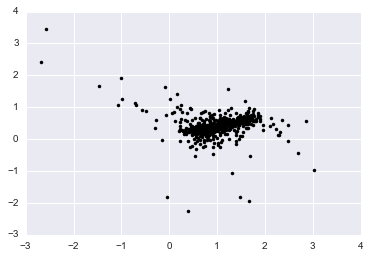

In [6]:
plt.figure('g-r vs r-i')

# data = SNIaCam[np.bitwise_and(
#         SNIaCam['g uncert'] < 0.01, SNIaCam['r uncert'] < 0.01, SNIaCam['i uncert'] < 0.01
#         )]
# plt.plot(data['g']-data['r'], data['r']-data['i'], 'k.')
plt.plot(SNIaCam['g']-SNIaCam['r'], SNIaCam['r']-SNIaCam['i'], 'k.')

This is mostly good. There are the few very bad colors that need to be corrected. Likey the errors of those outliers are bad.

## What are the values for a few SN looked at by Gupta 2011?

Lets look at the *ugriz* for SN1166, 1253 & 1371.

In [46]:
SNIaCam.columns
SNIaCam[np.logical_or(SNIaCam['CID']==1166, 
                      np.logical_or(SNIaCam['CID']==1253, SNIaCam['CID']==1371)
                     )][['CID', 'Z', 'MU', 'COLOR', 'X1', 'u', 'g', 'r', 'i', 'z']]

,CID,Z,MU,COLOR,X1,u,g,r,i,z
17,1166,0.382077,41.294899,0.001222,1.358340,25.311649,25.360130,25.333381,24.060039,23.495897
57,1371,0.119343,38.480900,-0.089316,0.818692,23.228621,21.517963,20.423611,19.999402,19.617180


SN1253 is not in the Campell data (or possibly the SMP, I doubt that), but it is in the Gupta analysis. Also the `color` and `x1` values do not match. Peter says that Gupta was using an early analysis and Campell is more complete so it does not matter too much if things changed. 

------

# FSPS

Charlie Conroy's Flexible Stellar Population Synthesis (FSPS), and dfm's python wrapper `python-fsps`, build simple stellar popuations (SSPs) and composite stellar populations (CSPs).

FSPS takes varring **IMFs** and **Metallicity** and produce simple stellar populations (SSPs) [note adjustments can be made via morphology of the horizontal branch, the blue straggler population, the post-AGB phase, and the location in the HR diagram of the TP-AGP phase.]. From these SSPs, we can get composite stellar populations (CSPs) for a variety of **star formation histories (SFHs)** and **dust attenuation**. This outputs **Spectra** and **magnitudes**.

[wrong idea:] So if I have a 5 parameter model (**IMFs**, **Metallicity**, **SFHs**, **dust attenuation**, and **redshift**) with a Gaussian prior of known redshift from spectra, we can get an output of the 5 `urigz` magnitudes. We can take our local environment SMP magnitudes and find the best fit model & uncertainty. This can be by doing some 1000 trials/fits or something (MCMC?). Our MCMC code could randomly walk the 5D space of the Chi-square of the model & data. Then for each SN we have our 5 (really 4 because we already new **z**) model parameters and some sort of certainty quantity.

[aside:] Gupta 2011 used 4 parameters metallicity log[Z/Z_solar], dust attenuating old stellar light, the e-folding timescale of star formation, the time when star formation begins. Table 1 explains range of parameters.

I need **age** somewhere. I want to compare HR to local stellar population age, metallicity and possibly SFH. I will use equation 3 of Gupta 2011. This function is calculated below.

## Parameters - changing

Some parameters will be **varried to build the modle space** and others will be *determined by the indvidual SN or a outcome of the model*. Aka, **bold** variables indicate size of model space and *italicized* variables will change with each SN/model but implicetly.

* *redshift*
    * fixed per SN by data
* *number of stars*
    * from the scalling factor in the minimization process
* *stellar age*
    * from `.get_mags()` with using default `tage` parameter. Resulting ages can be found with method `.log_age`. Alterniatively, look at `.log_lbol` and `.stellar_mass` and how these change with the flag `compute_light_ages`.
* SFH
    * Peter says the the we will mostly be able to see something like the ratio of new stars vs medium/old stars. Since most things older then a several Gyrs will all look very similar. This means we need to make sure our models are most unique at late time. We can either have a varring percentage of contant sfh but keep tau constant or we can do what Gupta and others do and have no constant sfh but allow for large tau's to get a similar effect.
    * uses six parameters: `tau`, `const`, `sf_start`, `sf_trunc`, `tburst`, and `fburst`
    * **`tau`** ($\tau_{\text{SF}}$)
        * Gupta used `[0.1, 0.5, 1, 2, 3, 4, 6, 8, 10]`
        * possible range is $0.1 < \tau < 10^2$
    * **`const`**
        * default is `0` and should change
    * **`sf_start`** $t_{\text{start}}$
        * default is `0`. This may not need to change ever.
    * `sf_trunc`
        * default is that it does not truncate
    * **`tburst`**
        * defines age of the Universe when the burst occurs.
        * defaults to 11.0
        * If `tburst` > `tage` then there is no burst.
            * we are using a wide ragne of `tage`
    * **`fburst`**
        * defines the fraction of mass formed in an instantaneous burst of star formation
        * defaults to 0.0
* **metallicity**
    * `zcontinuous`
        * 0 - no interpolation
        * 1 - interperalted with `logzsol`
        * 2 - (distribution fuction) convolved with both `logzsol` & `pmetals`

## Parameters - check defualts
* IMF
* Dust atinuation
* Dust emmition
* metallicity handeling
* compute_light_ages -> do not change! I am not sure what it does, but it does bad things.


In [42]:
import fsps

In [43]:
#Fast to set up model

# sdss_bands = fsps.find_filter('sdss')  #not in color order
sdss_bands = ['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z'] 

# use default Kroupa IMF
# use default settings for delayed tau-model SFH,
#    should change these to build model space.
# redshift & metalicity
#    Needs to be implemented
# Stellar Population
#    Need to turn a lot of things on from cloudy
# Dust
#    Use Milky Way extinction law - cant change A_v like Peter wants
#    Use default. Different optical depth for old and new stars. (like Charlot et al 2000)
#    using default `dust_tesc` of 7.0 Gyr
sp = fsps.StellarPopulation(zcontinuous=2, cloudy_dust=True, 
                            sfh=4)

In [41]:
def defineModelSpace(z):
    '''
    This builds the model space for a given redshift. The models need to know the redshfit of 
    the object to correctly callcualte the apprent magnitude as it changes over distance and 
    K-corrections
    
    # Parameters
    z : float
        The observed redshift of the objects
        
    # Returns
    modelSpace : ?
        The *ugriz* output of each model. Stored in a multi-demenial array. The 
        dimensions are for the changes in parameters `['logzsol', 'tau', 'sf_star', 'tburst',
        'fburst']` followed by time and finally the *ugriz* values. 
    '''
    #indexes are . . . , age (currently 107), fitlers
    modelSpace = np.zeros((6, 9, 8, 6, 5))
    
    #iterate over metalicity
    for i, met in enumerate([-0.88, -0.59, -0.39, -0.2, 0, 0.20]):
        #only gives 99 for a value of -1
        sp.params['logzsol'] = met
        
        #iterate over `tau`
        #e-folding time of of sfh in Gyr
        for j, tau in enumerate([0.1, 0.5, 1, 2, 3, 4, 6, 8, 10]):
            sp.params['tau'] = tau
            
            #iterate over `sf_start`
            #burst start time in Gyr
            for k, sf_start in enumerate([0, 1, 2, 3, 4, 5, 6, 7]):
                sp.params['sf_start'] = sf_start
                
                #iterate over dust
                for l, dust2 in enumerate([0, 0.1, 0.3, 0.5, 1.0, 1.5]):
                    #using default `dust_tesc` of 7.0 Gyr
                    #optical depth of young stars is 3x that of old.
                    #Conroy 2009 says Charlot 2000 recomends (dust1, dust2) = (1.0, 0.3)
                    dust1 = 3.0*dust2
                    sp.params['dust1'] = dust1
                    sp.params['dust2'] = dust2
    
                    #remove `tage` for real data?
                    tage = cosmo.age(z).to('Gyr').value
                    modelSpace[i,j,k,l] = sp.get_mags(tage=tage, redshift=z, bands=sdss_bands)
    
    return modelSpace

In [17]:
a = defineModelSpace(0.1)
a

array([[[[[ 46.89692383,  45.32813052,  44.54136634,  44.2347047 ,
            43.98775498],
          [ 47.05325672,  45.45572143,  44.64821192,  44.32820531,
            44.07041126],
          [ 47.36583134,  45.71077303,  44.86185575,  44.51517561,
            44.23569429]],

         [[ 46.82558712,  45.26845642,  44.48388417,  44.17872094,
            43.93575789],
          [ 46.98193161,  45.39605692,  44.59073244,  44.27222317,
            44.0184167 ],
          [ 47.29452933,  45.65112752,  44.80438163,  44.45919673,
            44.18370481]]],


        [[[ 46.73335382,  45.19206116,  44.41870391,  44.11818229,
            43.88039128],
          [ 46.88989719,  45.31972757,  44.52556889,  44.21169215,
            43.96305648],
          [ 47.20271193,  45.57490126,  44.73924499,  44.39867814,
            44.12835599]],

         [[ 46.63319141,  45.10738521,  44.3442116 ,  44.04805076,
            43.81551359],
          [ 46.78998347,  45.235125  ,  44.45109616,  44.14156

In [100]:
def saveModelSpace(data, fileName='resources/fspsModelSpace.csv'):
    """
    Save model space data at `resources/fspsModelSpace.csv`
    
    # Parameters
    
    data : multidimentional numpy array
        The *ugriz* outputs of the poly dimentional model space.
        
    fileName : string
        The name/location of where the file should be stored. 
    """
    
    #get curent date-time as string
    date = datetime.now().strftime('%Y-%m-%d')
    
    #file location
    fileName = 'resources/fspsModelSpace.csv'
    
    #create header information
    shape = data.shape
    header = "Flattened *ugriz* output on {} from model space generated from FSPS with dimmetions `['logzsol', 'tau', 'sf_star', 'tburst', 'fburst']` and shape {}".format(date, shape)
    
    #save data
    np.savetxt(fileName, data.flatten(), delimiter=',', header=header)

def readModelSpace(fileName='resources/fspsModelSpace.csv'):
    """
    reads saved, via `saveModelSapce()`, model space and reshapes it.
    
    # Parameters
    
    fileName : str
        
    # Returns
    
    modelSpace : multidimentional numpy array
        The *ugriz* outputs of the poly dimentional model space.
    """
    #get data
    data = np.loadtxt(fileName, delimiter=',')
    
    #get final shape
    with open(fileName, 'r') as f:
        firstLine = f.readline()
    
    shapeString = re.search(r'\d,.*\d', firstLine).group(0)
    shape = np.fromstring(shapeString, dtype=int, sep=',')
    
    #create modelSpace object
    modelSpace = data.reshape(shape)
    return modelSpace

Lets build & save all of the needed models

In [ ]:
for redshift in SNIaCam.dropna()['Z'].values:
    print('running z = '+str(redshift))
    defineModelSpace(redshift)
    fileName = 'resources/fspsModelSpace/fspsModelSpace_{}.csv'.formate(redshfit)
    saveModelSpace(data, fileName)

------

# Finding Correct Model

Going to stick with a model space per redshift and keep things discrete. Even though each space has 2592 models in it. Next we can minimize over continuous varriables, maybe with a better initial guess/ smaller space.

We will 
1. first calculate the $\chi^2$ for each model. 
2. Then calculate Probability Desnity Functions (PDFs) as $e^{\chi^2/2}$. 
3. From here we can get "confidance" intervals.

First lets calculate the $\chi^2$s.

In [82]:
def chisquare(c, model, dataDF):
    """
    A chi-square function to minimize the scalling factor that brings up the FSPS model to
    the observed *ugriz* values. This scaleing factor will be used to calculate the mass of 
    the stellar population. The model and the data should be fixed values.
    
    # Parameters
    
    c : float
    
    model : array
        This is the output of the FSPS models. Needs to be in the order `['u', 'g', 'r', 'i', 'z']`. 
        
    dataDF : DataFrame
        This is the observed data. Needs to contain `['u', 'g', 'r', 'i', 'z', 'u uncert',
        'g uncert', 'r uncert', 'i uncert', 'z uncert']`
        
    # Returns
    
    chi_square : float
        The chi-square for the given data, model and scalling parameter. 
    """
    data = dataDF[['u', 'g', 'r', 'i', 'z']].values
    uncert = dataDF[['u uncert', 'g uncert', 'r uncert', 'i uncert', 'z uncert']].values
    
    return np.sum((model+c-data)**2/uncert**2)

In [97]:
chisquare(18, a[0,0,0,0], SNIaCam.loc[0, ['u', 'u uncert', 'g', 'g uncert', 'r', 'r uncert', 'i', 'i uncert', 'z', 'z uncert']])

39847830.544373259

------

# Start Comparing Varriables

The main comparison will be HR vs Stellar population Age. We may also use SN Ia varriables like `color`, `stretch`, or $\Delta m_{15}$. Other stellar population paramteters may be mass (from r band magnitude) or mass from the fitting constant parameter `c`.

In [56]:
def calculateMassAge(z, sf_start, tau,):
    """Calculate the mass weighted age as described by Gupta 2011 equatoin 3.
    Requires `scipy.inegrate` to be importate as well as your favorate cosmology to be in 
    `cosmo` such as: `from astropy.cosmology import WMAP9 as cosmo` or 
    `from astropy.cosmology import FlatLambdaCDM` `cosmo = FlatLambdaCDM(H0=70, Om0=0.27)`. 
    The SFH model is a basic $\tau$-model with NO constant SF NOR an instantanious burst.
    
    # Parameters
    
    z : float
        The redshift of the given stellar population. 
    
    sf_start : float
        The start time of the star formation in Gyr from the start of the Universe.
        
    tau : float
        The e-folding time in Gyr of the $\tau$-model of SF.
        
    # Returns
    
    age : float
        The computed mass weighted age.
    """
    
    ageOfUniverse = cosmo.age(z)
    lengthOfSF = ageOfUniverse.to('Gyr').value - sf_start
    
    sfFunc = lambda t: np.e**(-t/tau) if t >= sf_start else 0
    sfTFunc = lambda t: t*sfFunc(t)
    
    numerator = integrate.quad(sfTFunc, 0, lengthOfSF)[0]
    denominator = integrate.quad(sfFunc, 0, lengthOfSF)[0]
    
    return lengthOfSF - numerator/denominator
    

# Scratch Area!